In [134]:
import numpy as np
import os
import os.path
import src.visualization.display as dsp
import netCDF4 as nc
import matplotlib.pyplot as plt
import torch
from pytorch_lightning import Trainer,seed_everything,LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import src.unet as unet
import src.cnn as cnn
import scipy.ndimage.morphology as scm
import importlib
import matplotlib.ticker as mtick
from scipy import interpolate
importlib.reload(cnn)

<module 'src.cnn' from '/Users/skrunes/Documents/DL-normalization/src/cnn.py'>

In [78]:
os.getcwd()
os.chdir("DL-normalization/")
os.getcwd()

'/Users/skrunes/Documents/DL-normalization'

In [136]:
#model = unet.Unet.load_from_checkpoint("results/wandb/cnn_nemo/cnn_nemo/checkpoints/epoch=785-val_loss=0.00003.ckpt")
model = cnn.CNN.load_from_checkpoint("results/wandb/cnn_nemo/cnn_nemo/checkpoints/epoch=785-val_loss=0.00003.ckpt")
X = np.load("data/processed/nemonemo_perten190_samples_standardize/valid/X/NORSSH_PERTEN15.npz")['arr_0']
Y = np.load("data/processed/nemonemo_perten190_samples_standardize/valid/Y/NORSSH_PERTEN15_norm_coeffs.npz")['arr_0'][29:-29,28:-28]
X=torch.from_numpy(X[np.newaxis,:]).float()

std = 85067.5426020621
mean = 519020.0674039183

print(X.shape)
#X = X[:,:,10:-10,:]

#plt.imshow(X[0,0,:,:])

#X=X
#Y=np.load("data/processed/isotropic_noise100_samples_standardize/valid/Y/sphere_polecontinent106_norm_coeffs.npz")['arr_0']
mask = np.where(Y==0,True,False)
Y = Y*std + mean
Y_pred = model.forward(X).detach().numpy()[0,0,29:-29,28:-28]*std + mean
#mask = np.where(Y==0,True,False)
eps = (Y_pred**2 - Y**2)/Y**2
#eps[mask] = 100
eps =np.ma.masked_array(eps, mask)
#mse=((Y_pred - Y)**2)

torch.Size([1, 3, 352, 416])


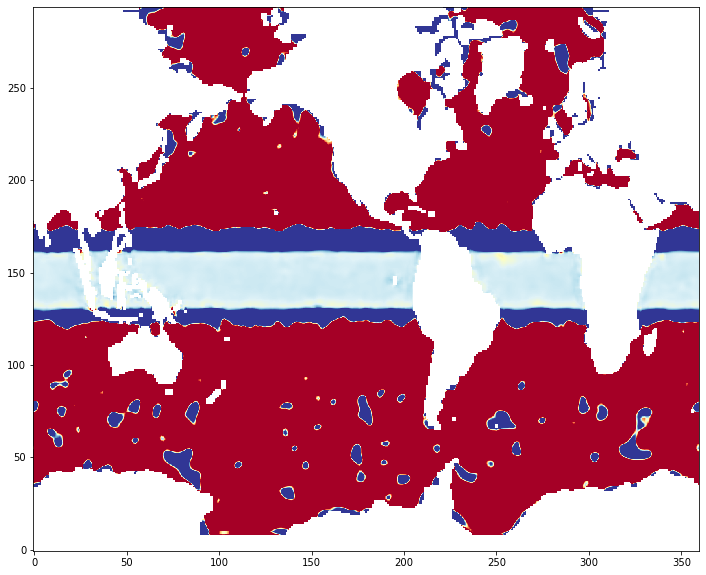

In [137]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)

axs.imshow(eps[:,:],origin="lower",vmin=-0.05,vmax=0.05,cmap="RdYlBu")

In [88]:
with nc.Dataset("data/rando10000.nc","r") as data:
    eps_rnd = data["diff"][:]
    norm = data["norm_coeffs"][:]
    norm_rnd = data["norm_coeffs_rnd"][:]

In [100]:
mask_rnd=torch.from_numpy(np.ma.getmask(eps_rnd[20:-20,:]))
eps_torch=torch.from_numpy(eps_rnd[20:-20,:].flatten()).float()
print(torch.quantile(torch.abs(eps_torch.flatten()[torch.flatten(~mask_rnd)]),0.9999))

#q_res = torch.quantile(
#            masked_abs_rel_error[torch.flatten(mask_true)], q)

tensor(0.0532)


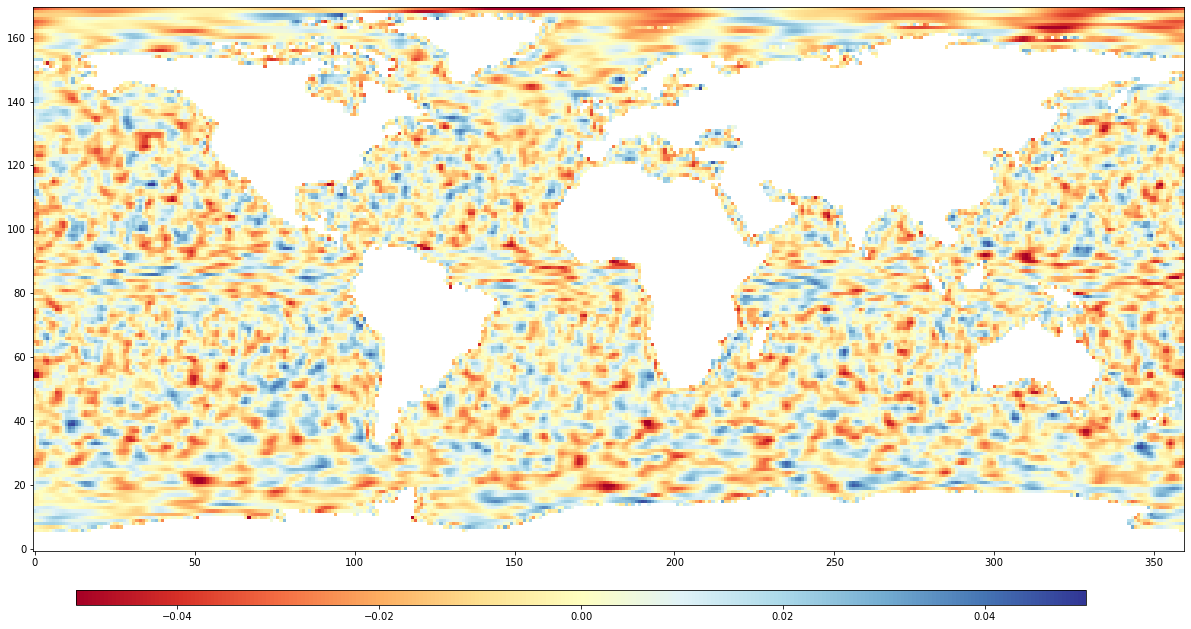

In [117]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)

c = axs.imshow(np.roll(eps_rnd[5:-5,:],180,axis=1),origin="lower",vmin=-0.05,vmax=0.05,cmap="RdYlBu")
#cbar=fig.colorbar(c, cax=cbar_ax,orientation='horizontal')
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

In [101]:
print(torch.max(torch.abs(eps_torch[torch.flatten(~mask_rnd)])))

tensor(0.0565)


In [99]:
print(torch.mean(torch.abs(eps_torch[torch.flatten(~mask_rnd)])))

tensor(0.0113)


In [93]:
print(np.mean(mask_rnd))

0.2554166666666667


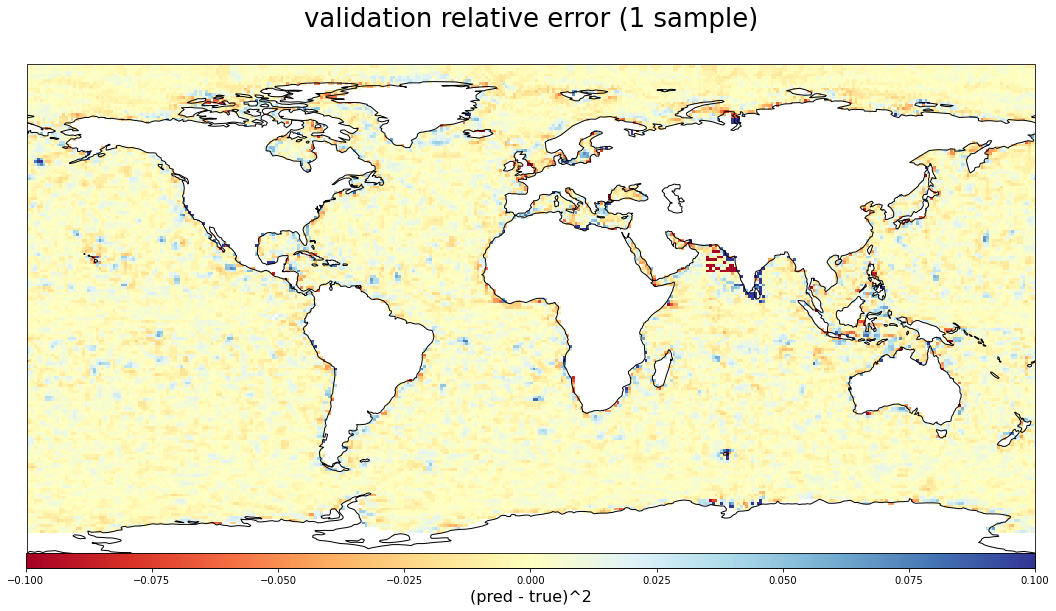

In [42]:
nemo_lats = np.loadtxt("data/lats.txt")[1:-1,1:-1]
nemo_lons = np.loadtxt("data/lons.txt")[1:-1,1:-1]

lon = np.arange(-180, 180)
lat = np.arange(-90, 90)
lon2d, lat2d = np.meshgrid(lon, lat)

points_nemo = []
points_mercator = []

pad = 10

pad_lons = np.empty((290,360 + 2 * pad))
pad_lons[:,pad:-pad] = np.copy(nemo_lons)
pad_lons[:,:pad] = np.copy(pad_lons[:,-2*pad:-pad])
pad_lons[:,-pad:] = np.copy(pad_lons[:,pad:2*pad])

pad_lats = np.empty((290,360 + 2 * pad))
pad_lats[:,pad:-pad] = np.copy(nemo_lats)
pad_lats[:,:pad] = np.copy(pad_lats[:,-2*pad:-pad])
pad_lats[:,-pad:] = np.copy(pad_lats[:,pad:2*pad])

for i in range(len(pad_lons)):
    for j in range(len(pad_lons[0])):
        points_nemo.append((pad_lons[i,j],pad_lats[i,j]))

        
for i in range(-90,90):
    for j in np.concatenate((np.arange(-10,180),np.arange(-180,10))):
        points_mercator.append((j,i))

padded=np.copy(eps)
interp1 = np.nan_to_num(interpolate.griddata(points_nemo,padded.flatten(), 
                                            points_mercator,method="nearest")).reshape((180,380))

mask = np.where(interp1>2,True,False)
dsp.plot_error_globe(np.ma.masked_array(interp1, mask)[:,10:-10], lon2d, lat2d,vmin=-0.1,vmax=0.1,cmap="RdYlBu",
                     cmap_title="(pred - true)^2",title="validation relative error (1 sample)")